### Loading Libraries and Reading in Data

In [19]:
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


# Reading in hit dataset
df = pd.DataFrame(columns=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'at_bat_number', 'pitch_number', 'pitch_name', 'home_score', 'away_score', 'bat_score', 'fld_score', 'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score', 'if_fielding_alignment', 'of_fielding_alignment'])

for year in range(2015, 2020):
    for i in range(1, 3):
        df = df.append(pd.read_csv("data/%dHits%d.csv"%(year, i)), ignore_index=True)
        
df["inning"] = df["inning"].astype(int)
df["balls"] = df["balls"].astype(int)
df["strikes"] = df["strikes"].astype(int)
df["outs_when_up"] = df["outs_when_up"].astype(int)

# Research Question #1

- Given that a pitch resulted in a hit, use data about the pitch to predict which type of hit occurred (single, double, triple, or home run). Also, if predictions are accurate, which variables are the most important in determining the outcome of the hit?


- We will train both a neural network and a random forest classifier to attempt to answer this question. We will then estimate feature importance using methods seen during class.

- The variable names and descriptions are explained on [Statcast's Website](https://baseballsavant.mlb.com/csv-docs)

## Random Forest Model

For the Random Forest Classifier, we used scikit-learn's model and attempted a few combinations of variables, depending on which types of explanatory variables we wanted to include.

For example, some of the variables were things that happened after the pitch such as where the ball was fielded or which player fielded the ball. There were also variables that happended during the hit, such as the launch angle or the launch speed of the ball, so we wanted to try another model where we only included variables that were known after the pitch was throw, but before contact with the bat actually occured.

Below is our initial model which includes all of the relevant variables, included fielding location, launch angle, speed, pitch type, and ball-strike count on the batter.

In [4]:
subset1 = df[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'p_throws', 'balls', 'strikes', 
         'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
         'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'launch_speed', 'launch_angle',
         'effective_speed', 'release_spin_rate', 'release_extension', 'events']]

subset1 = subset1.dropna()

X = subset1.drop("events", axis=1)
X = pd.get_dummies(X)
y = subset1["events"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

print((rf.predict(X_test) == y_test).sum() / len(y_test))
pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_}).sort_values("Importance", ascending=False).head()

0.8851227116476137


,Feature,Importance
12,hc_y,0.204248
22,launch_angle,0.186580
11,hc_x,0.184202
21,launch_speed,0.087159
7,plate_x,0.020521


As we can see above, our model is achieving accuracies of around 88%, and the driving features of our model are the x and y positions of where the ball was fielded as well as the launch angle and speed of the hit, and finally the x position of where the ball crossed the plate.

Next we trained a model after removing the position of where the ball was fielded to see how the model performed.

In [9]:
subset2 = df[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'p_throws', 'balls', 'strikes', 
         'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning', 'inning_topbot',
         'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'launch_speed', 'launch_angle',
         'effective_speed', 'release_spin_rate', 'release_extension', 'events']]

subset2 = subset2.dropna()

X = subset2.drop("events", axis=1)
X = pd.get_dummies(X)
y = subset2["events"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

print((rf.predict(X_test) == y_test).sum() / len(y_test))
pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_}).sort_values("Importance", ascending=False).head()

0.8238156005742543


,Feature,Importance
20,launch_angle,0.299847
19,launch_speed,0.159229
7,plate_x,0.031191
8,plate_z,0.028231
23,release_extension,0.026102


Our accuracy dropped to around 82%, and the predictions are now being driven by the launch angle and speed, as well as the x and z location of where the pitch crossed the plate. The release extension also showed up in the top 5 most important features.

Lastly, we removed the launch speed and angle from the data, to see what would now be driving the predictions of our model.

In [10]:
subset3 = df[['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z', 'zone', 'p_throws', 'balls', 'strikes', 
         'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'outs_when_up', 'inning', 'inning_topbot',
         'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate',
         'release_extension', 'events']]

subset3 = subset3.dropna()

X = subset3.drop("events", axis=1)
X = pd.get_dummies(X)
y = subset3["events"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)

print((rf.predict(X_test) == y_test).sum() / len(y_test))
pd.DataFrame({"Feature": X.columns, "Importance": rf.feature_importances_}).sort_values("Importance", ascending=False).head()

0.6412607906856197


,Feature,Importance
7,plate_x,0.055729
8,plate_z,0.051995
15,ay,0.049671
20,release_spin_rate,0.049082
21,release_extension,0.049028


Our accuracy has now dropped down to 64%, which is a large decrease compared to the previous change. It looks like the launch angle and launch speed were significant predictors of what type of hit occurred.

The feature importance is now much more evenly distributed between the variables, and is now being driven by the x and z location of the pitch, the acceleration in the y direction, and finally the release spin rate, and release extension of the pitcher.

## Neural Network Model

We decided that the best subset of variables to use was the set that included features of the hit such as launch angle, and launch speed, but not features that occur in the field, such as the player who fielded it or the location of the fielder.

Below, we test out various layer sizes of our neural network model.

In [13]:
X = subset2.drop("events", axis=1)
X = pd.get_dummies(X)
y = subset2["events"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y)

layer_size_list = [(10,), (20,), (5,5), (10,10), (20,10), (10, 10, 10)]

for layer_sizes in layer_size_list:
    nn = MLPClassifier(solver='adam', hidden_layer_sizes=layer_sizes, random_state=1)
    nn.fit(X_train_sc, y_train_sc)
    score = (nn.predict(X_test_sc) == y_test_sc).sum() / len(y_test_sc)
    print(layer_sizes, score)

(10,) 0.8288403254107514
(20,) 0.8295382038602648
(5, 5) 0.8295780826288084
(10, 10) 0.8288203860264794
(20, 10) 0.829079598022013
(10, 10, 10) 0.8298971127771574


As we can see above, the best layer size seems to be the (10, 10, 10) layer size, which achieves an accuracy of around 83%.

Below, we can see a confusion matrix of our predictions. Since triples rarely occurred in games, we can see that the neural network never predicted a triple as a hit. It looks like the biggest misclassification came from doubles being misclassified as singles, and it looks like over half of all of the actual doubles were misclassified.

In [20]:
labels = ["single", "double", "triple", "home_run"]
results = pd.DataFrame({"Actual": y_test_sc, "Predicted": nn.predict(X_test_sc)})
pd.DataFrame(confusion_matrix(results["Actual"], results["Predicted"], labels=labels), columns=labels, index=labels)

,single,double,triple,home_run
single,31032,1144,0,78
double,4500,4223,0,1193
triple,333,383,0,248
home_run,11,641,0,6366


# Research Question #2

- Given movement and positional information of a pitch, can we predict if a pitch will be called a ball or a strike by the umpire? When the pitch is on the edges of the strike zone, which features are most important in determining whether it is called a ball or strike?



- We will train an extreme gradient boosting model as well as attempting a clustering technique to try and predict the outcome of the pitch. We really want to see which features are driving the predictions and see if there is a clear factor that contributes to umpires missing the call. 

### Loading Libraries and Reading in Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import Birch
from sklearn.cluster import SpectralClustering
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import cross_val_score
%matplotlib inline
import warnings
warnings.simplefilter("ignore")

In [2]:
df_pitch = pd.read_csv("fullpitch.csv")
df_pitch["sz_r_edge"] = 19.94/24
df_pitch["sz_l_edge"] = -19.94/24
df_pitch["sz_call"] = ((df_pitch["plate_z"] <= df_pitch["sz_top"]) & (df_pitch["plate_z"] >= df_pitch["sz_bot"]) & 
                       (df_pitch["plate_x"] >= df_pitch["sz_l_edge"]) & (df_pitch["plate_x"] <= df_pitch["sz_r_edge"]))
df_pitch["sz_call"] = df_pitch["sz_call"].replace(True, "strike")
df_pitch["sz_call"] = df_pitch["sz_call"].replace(False, "ball")
features = ['pitch_type', 'release_speed', 'release_pos_x',
            'release_pos_z', 'stand', 'release_pos_y', 'vx0', 'vy0', 'vz0', 
            'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'pitch_number',
           'sz_call', 'sz_l_edge', 'sz_r_edge', 'zone', 'p_throws', 'strikes', 'balls',
           'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'release_spin_rate', 'release_extension']
X = df_pitch[features].dropna()
y = df_pitch["description"].replace("called_strike", "strike")
y = y.replace(["blocked_ball", "pitchout"], "ball")
y = y.loc[X.index]

We loaded in all the pitch data (the way we created the csv "fullpitch" is in the UmpAnalysis notebook, but the code was too long to put in). The features sz_r_edge and sz_l_edge represent the edges of the strike zone in feet. We used these features and the sz_top and sz_bottom to say whether the pitch should have been a strike or not, based on if it is in those boundaries. 

### Plot of Strikes and Balls

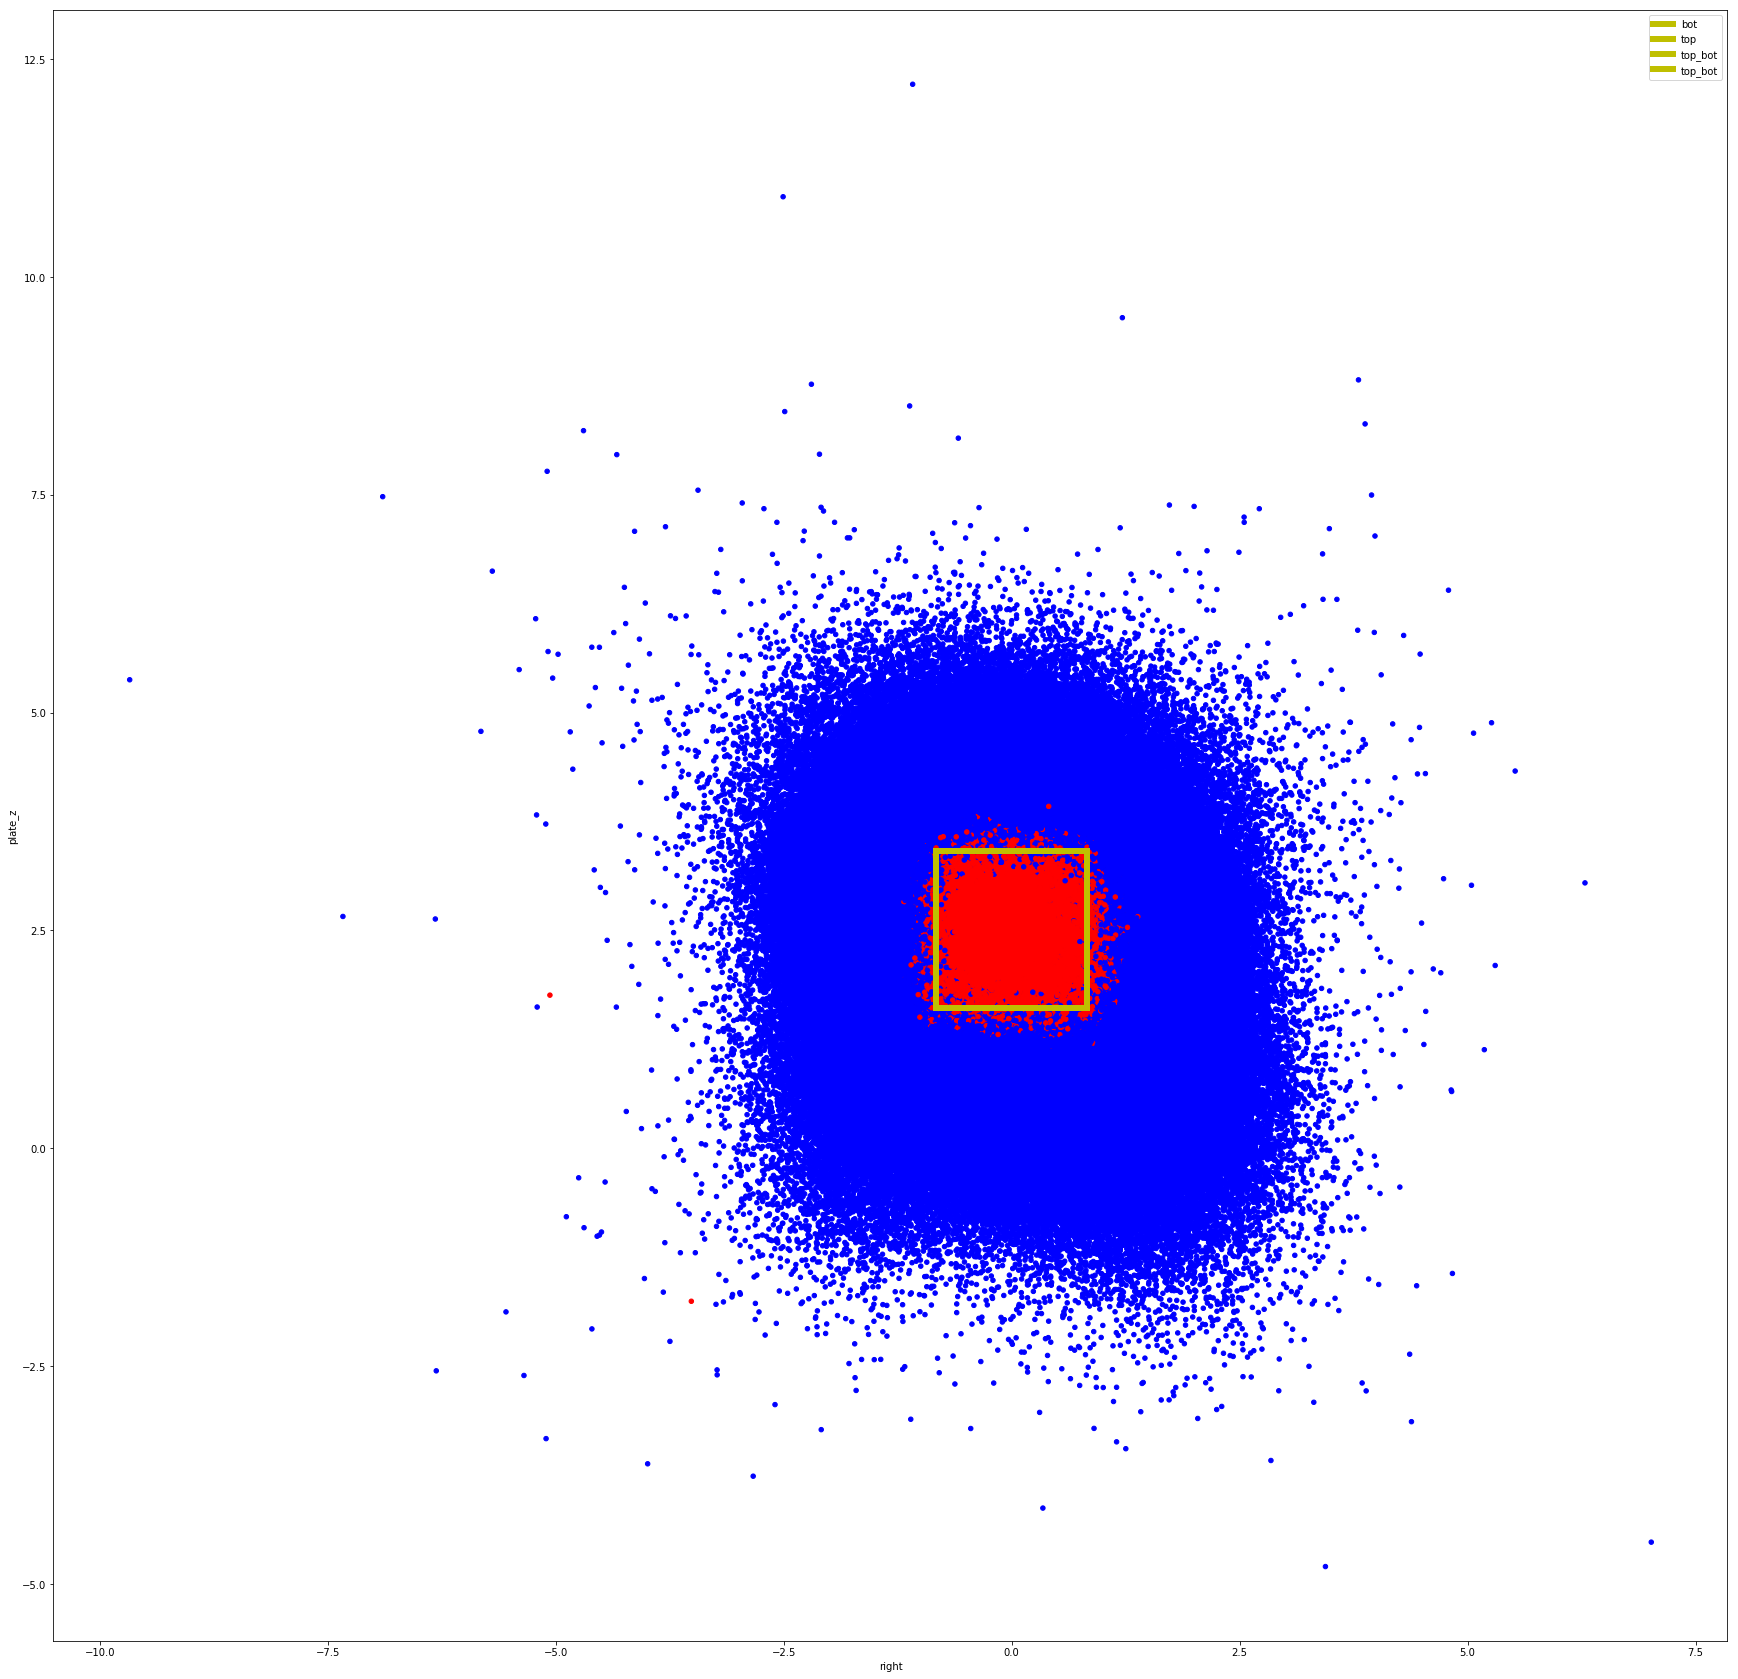

In [3]:
plot_df = X.copy()
plot_df["ump_call"] = y
coloring = plot_df["ump_call"].map({"ball": "Blue", "strike": "Red"})
ax = plot_df.plot.scatter("plate_x", "plate_z", c=coloring, figsize=(30,30))
yellows = pd.DataFrame()
yellows["x"] = [0.8303333333, -0.8303333333]
yellows["bot"] = np.mean(df_pitch["sz_bot"])
yellows["top"] = np.mean(df_pitch["sz_top"])
ax2 = yellows.plot("x", "bot", c='y', figsize=(30,30), lw=6,ax=ax)
ax3 = yellows.plot("x", "top", c='y', figsize=(30,30), lw=6,ax=ax2)
yellows
yellows2 = pd.DataFrame()
yellows2["top_bot"] = [np.mean(df_pitch["sz_bot"]), np.mean(df_pitch["sz_top"])]
yellows2["left"] = -0.8303333333
yellows2["right"] = 0.8303333333
ax4 = yellows2.plot("left", "top_bot", c='y', figsize=(30,30),lw=6, ax=ax3)
yellows2.plot("right", "top_bot", c='y', figsize=(30,30),lw=6, ax=ax4)

Plotted all our data - blue being a ball and red being a strike. The yellow box represents the average strike zone size. We can clearly see the target that we want our models to identify, so we will take out the features that say where the pitch ended up and the strike zone heighth and width. 

In [1]:
features = ['pitch_type', 'release_speed', 'release_pos_x',
            'release_pos_z', 'stand', 'release_pos_y', 'vx0', 'vy0', 'vz0', 
            'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'pitch_number']

In [ ]:
tester = df_pitch[features]
scaler = StandardScaler()
df_pitch_dum = pd.get_dummies(tester)
scaler.fit(df_pitch_dum)
X = scaler.transform(df_pitch_dum)
X = pd.DataFrame(X,columns=df_pitch_dum.columns)
X.dropna(inplace=True)
y = df_pitch["description"].replace("called_strike", "strike")
y = y.replace(["blocked_ball", "pitchout"], "ball")
ind = X.index
y = y.loc[ind]

Here are the intial features we took a look at.

## Clustering Algorithms

Here we used a few of scikit-learn's clustering algorithms to see how they would do at predicting balls and strikes. We looked Agglomerative Clustering, KMeans, and Birch clustering. Agglomerative Clustering kept leaving one pitch as its own group so we decided to not use Agglomerative Clustering. 

#### Initial Models

Below we can see the intitial F1 scores based on the features above.

In [ ]:
clusters = {}
clusters["ward"] = AgglomerativeClustering(n_clusters=2)
clusters["average"] = AgglomerativeClustering(n_clusters=2, linkage="average")
clusters["KMeans"] = MiniBatchKMeans(n_clusters=2)
clusters["Birch"] = Birch(n_clusters=2)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.001, train_size=0.005, random_state=42)
results = pd.DataFrame(y_test)
for key in list(clusters.keys()):
    print(clusters[key])
    clusters[key].fit(X_train, y_train)
    if key == "ward" or key == "average":
        results[key] = clusters[key].fit_predict(X_test)
    else:
        results[key] = clusters[key].predict(X_test)

In [1]:
f1s

NameError: name 'f1s' is not defined

### Final Models

In [24]:
features3 = ['pitch_type', 'release_speed', 'release_pos_x',
            'release_pos_z', 'stand', 'release_pos_y', 'vx0', 'vy0', 'vz0', 
            'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'pitch_number']

#### KMeans

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X[features3[:16]], y, test_size=0.25, train_size=0.75, random_state=42)
y_encode_train = (y_train == "ball").astype(int)
y_encode_test = (y_test == "ball").astype(int)
model = MiniBatchKMeans(n_clusters=2)

bad_col = []
if pd.get_dummies(X_train).shape[1] != pd.get_dummies(X_test).shape[1]:
    for col in list(pd.get_dummies(X_train).columns):
        if col not in list(pd.get_dummies(X_test).columns):
            bad_col.append(col)

for bpitch in bad_col:
    ind = X_train[X_train.pitch_type == bpitch[-2:]].index
    X_train.drop(ind, axis=0, inplace=True)
    y_encode_train.drop(ind, inplace=True)
    y_encode_test.drop(ind, inplace=True)
    y_train.drop(ind, inplace=True)


X_train_dict = X_train.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(X_train_dict)
scaler = StandardScaler()
scaler.fit(X_train)
X_sc = scaler.transform(X_train)

X_test_dict = X_test.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
X_test = vec.fit_transform(X_test_dict)
scaler = StandardScaler()
scaler.fit(X_test)
X_sctest = scaler.transform(X_test)

model.fit(X_sc, y_train)
y_pred = model.predict(X_sctest)
display(f1_score(y_encode_test, y_pred))

Kresults = pd.DataFrame()
Kresults["Calls"] = y_encode_test.map({0:"strike", 1:"ball"})
Kresults["Prediction"] = pd.Series(y_pred, index = Kresults.Calls.index).map({0:"strike", 1:"ball"})
pd.crosstab(Kresults.Calls, Kresults.Prediction)

0.6390098831445823

Prediction,ball,strike
Calls,,
ball,116996,74181
strike,58006,30832


Here we optimized the feature selection by taking the features above (which are listed in order of importance based on a decision tree) and added them one by one to see when the algorithm performed the best. The first 16 features produced the best result so we made a subset with those features and used that to make the KMeans model. We got an F1 score of .639 which wasn't great but better than our inital model which got a F1 score of 0.597.

#### Birch

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X[features3[:14]], y, test_size=0.002, train_size=0.01, random_state=42)
y_encode_train = (y_train == "ball").astype(int)
y_encode_test = (y_test == "ball").astype(int)
model = Birch(n_clusters=2)

bad_col = []
if pd.get_dummies(X_train).shape[1] != pd.get_dummies(X_test).shape[1]:
    for col in list(pd.get_dummies(X_train).columns):
        if col not in list(pd.get_dummies(X_test).columns):
            bad_col.append(col)

for bpitch in bad_col:
    ind = X_train[X_train.pitch_type == bpitch[-2:]].index
    X_train.drop(ind, axis=0, inplace=True)
    y_encode_train.drop(ind, inplace=True)
    y_train.drop(ind, inplace=True)


X_train_dict = X_train.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(X_train_dict)
scaler = StandardScaler()
scaler.fit(X_train)
X_sc = scaler.transform(X_train)

X_test_dict = X_test.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
X_test = vec.fit_transform(X_test_dict)
scaler = StandardScaler()
scaler.fit(X_test)
X_sctest = scaler.transform(X_test)

model.fit(X_sc, y_train)
y_pred = model.predict(X_sctest)
display(f1_score(y_encode_test, y_pred))

Bresults = pd.DataFrame()
Bresults["Calls"] = y_encode_test.map({0:"strike", 1:"ball"})
Bresults["Prediction"] = pd.Series(y_pred, index = Bresults.Calls.index).map({0:"strike", 1:"ball"})
pd.crosstab(Bresults.Calls, Bresults.Prediction)

0.6135652173913044

Prediction,ball,strike
Calls,,
ball,882,627
strike,484,248


Here we optimized the feature selection by the same method described above in the KMeans section. The first 14 features produced the best result so we made a subset with those features and used that to make the model. We got an F1 score of 0.61 which wasn't great but better than our inital model which got a F1 score of 0.55.



Overall, clustering algorithms were not that effective, even with the strike zone height, which we hoped would help it be able to cluster better. 

## Extreme Gradient Boosting

We loaded in the XGBoost library and used the XGB classifier to see how that would do with our data. The initial model we trained got an F1 score of 0.88 with inital feature selection.  

In [37]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
results["xgb"] = y_pred


In [39]:
f1_score(results["yencode"], (results["xgb"]=="ball").astype(int))

0.8818897637795275

While going through this XGB classifier, we thought it would be a good idea to compare it with a Random Forest Classifier to see the differences and similarities. Here is our inital Random Forest Classifier on the initial features.

In [31]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
results["randforest"] = clf.predict(X_test)

In [34]:
f1_score(results["yencode"], (results["randforest"]=="ball").astype(int))

0.8481152993348114

Using the XGB classifier with the first 13 features from the list below, we then ran through to see the best number of estimators to use which we found was 400. Below I also found the best number of estimators to use for a Random Forest Classifier, which was 200. The first 6 features were the best for the Random Forest model.

In [13]:
new_features2 = ['pitch_type', 'vz0','vx0','release_pos_x','ax','az', 'stand','release_pos_z','pitch_number',
                 'vy0','effective_speed','ay','release_pos_y','sz_bot','sz_top','release_speed', 'release_extension',
                'balls', 'strikes', 'sz_l_edge', 'sz_r_edge', 'pfx_x', 'pfx_z']

In [ ]:
true_features = new_features2[:13]
#XGB
X_xgb = X[true_features]
X_clf = X[new_features2[:6]]
trees = [100, 150, 200, 250, 300, 350, 400, 450, 500]
X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_xgb, y, test_size=0.001, train_size=0.005, random_state=42)
y_encode_trainb = (y_trainb == "ball").astype(int)

X_train_dict = X_trainb.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(X_train_dict)
scaler = StandardScaler()
scaler.fit(X_train)
X_scb = scaler.transform(X_train)

X_trainf, X_testf, y_trainf, y_testf = train_test_split(X_clf, y, test_size=0.001, train_size=0.005, random_state=42)
y_encode_trainf = (y_trainf == "ball").astype(int)

X_train_dict = X_trainf.to_dict(orient="records")
vec = DictVectorizer(sparse=False)
X_train = vec.fit_transform(X_train_dict)
scaler = StandardScaler()
scaler.fit(X_train)
X_scf = scaler.transform(X_train)

best_tree = pd.DataFrame()

for name in ["XGB", "RandForest"]:
    tr = []
    for tree in trees:
        if name == "XGB":
            model = xgb.XGBClassifier(n_estimators=tree, objective="binary:logistic", random_state=42)
            pipeline = Pipeline([("fit", model)])
            tr.append(np.mean(cross_val_score(
                 pipeline, X_scb, y_encode_trainb, 
                cv=5, scoring="f1"
            )))
        else:
            model = RandomForestClassifier(n_estimators=tree, random_state=42)
            pipeline = Pipeline([("fit", model)])
            tr.append(np.mean(cross_val_score(
                 pipeline, X_scf, y_encode_trainf, 
                cv=5, scoring="f1"
            )))
    best_tree[name] = tr
best_tree["NumTrees"] = trees
best_tree = best_tree.set_index("NumTrees")

In [19]:
print("XGB", best_tree.XGB.idxmax())
print("RF", best_tree.RandForest.idxmax())

XGB 400
RF 250


Below is our best Extreme Gradient Boosting Model.
We got a F1 score 0.91 which was a good improvement from our initial model. It also beat out the Random Forest Classifier as that model only got a 0.87 F1 score. 
We also get a glimpse into the idea that the vertical acceleration, release point and whether the batter is a righty or lefty plays the most into whether a pitch that is close or not close to the zone, will be called a ball or strike.

In [20]:
f1s = []
for i in range(5):
    X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_xgb, y, test_size=0.005, train_size=0.015, random_state=42)
    y_encode_trainb = (y_trainb == "ball").astype(int)
    y_encode_testb = (y_testb == "ball").astype(int)

    bad_col = []
    if pd.get_dummies(X_trainb).shape[1] != pd.get_dummies(X_testb).shape[1]:
        for col in list(pd.get_dummies(X_trainb).columns):
            if col not in list(pd.get_dummies(X_testb).columns):
                bad_col.append(col)

    for bpitch in bad_col:
        ind = X_trainb[X_trainb.pitch_type == bpitch[-2:]].index
        X_trainb.drop(ind, axis=0, inplace=True)
    y_encode_trainb.drop(ind, inplace=True)
    y_trainb.drop(ind, inplace=True)


    X_train_dict = X_trainb.to_dict(orient="records")
    vec = DictVectorizer(sparse=False)
    X_train = vec.fit_transform(X_train_dict)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_scb = scaler.transform(X_train)

    X_test_dict = X_testb.to_dict(orient="records")
    vec = DictVectorizer(sparse=False)
    X_test = vec.fit_transform(X_test_dict)
    scaler = StandardScaler()
    scaler.fit(X_test)
    X_scbtest = scaler.transform(X_test)

    model = xgb.XGBClassifier(n_estimators=400, objective="binary:logistic")
    model.fit(X_scb, y_trainb)
    y_predb = model.predict(X_scbtest)

    f1s.append(f1_score(y_encode_testb, (y_predb=="ball").astype(int)))
np.mean(f1s)

0.913138592201776

In [42]:
importancesxg = pd.DataFrame(model.feature_importances_, index=pd.get_dummies(X_testb).columns, columns=["Importance"])
importancesxg.Importance.sort_values(ascending=False).head(10)

az               0.131067
stand_R          0.087500
release_pos_z    0.076042
release_pos_x    0.068506
pitch_type_FT    0.061128
pitch_type_SL    0.060318
vz0              0.060112
release_pos_y    0.057609
pitch_type_KN    0.044053
pitch_type_FF    0.042850
Name: Importance, dtype: float32

In [22]:
Results = pd.DataFrame()
Results["Calls"] = y_encode_testb.map({0:"strike", 1:"ball"})
Results["Prediction"] = pd.Series(y_predb, index = Results.Calls.index)
pd.crosstab(Results.Calls, Results.Prediction)

Prediction,ball,strike
Calls,,
ball,3548,286
strike,389,1378


## Ump versus Strike Zone Comparison

Now we wanted to look and see the difference of our model predicting the ump's calls of balls and strike versus what the strike zone would have called. We really wanted to see what the difference in feature importance would be, as this could be a good clue as to what umpires biggest faults are.

In [34]:
y_ump = df_pitch["sz_call"]
y_ump = y_ump.loc[X_xgb.index]

In [35]:
f1snew = []
for i in range(5):
    X_trainb, X_testb, y_trainb, y_testb = train_test_split(X_xgb, y_ump, test_size=0.005, train_size=0.015, random_state=42)
    y_encode_trainb = (y_trainb == "ball").astype(int)
    y_encode_testb = (y_testb == "ball").astype(int)

    bad_col = []
    if pd.get_dummies(X_trainb).shape[1] != pd.get_dummies(X_testb).shape[1]:
        for col in list(pd.get_dummies(X_trainb).columns):
            if col not in list(pd.get_dummies(X_testb).columns):
                bad_col.append(col)

    for bpitch in bad_col:
        ind = X_trainb[X_trainb.pitch_type == bpitch[-2:]].index
        X_trainb.drop(ind, axis=0, inplace=True)
        y_encode_trainb.drop(ind, inplace=True)
        y_trainb.drop(ind, inplace=True)


    X_train_dict = X_trainb.to_dict(orient="records")
    vec = DictVectorizer(sparse=False)
    X_train = vec.fit_transform(X_train_dict)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_scb = scaler.transform(X_train)

    X_test_dict = X_testb.to_dict(orient="records")
    vec = DictVectorizer(sparse=False)
    X_test = vec.fit_transform(X_test_dict)
    scaler = StandardScaler()
    scaler.fit(X_test)
    X_scbtest = scaler.transform(X_test)

    model = xgb.XGBClassifier(n_estimators=400, objective="binary:logistic")
    model.fit(X_scb, y_trainb)
    y_predb = model.predict(X_scbtest)

    f1snew.append(f1_score(y_encode_testb, (y_predb=="ball").astype(int)))
np.mean(f1snew)

0.9270582571015888

In [46]:
importancesxgnew = pd.DataFrame(model.feature_importances_, index=pd.get_dummies(X_testb).columns, columns=["Importance"])
importancesxgnew.Importance.sort_values(ascending=False).head(10)

release_pos_z    0.124072
az               0.107375
stand_R          0.076482
pitch_type_SL    0.068268
release_pos_x    0.064705
pitch_type_FT    0.063058
release_pos_y    0.061663
vz0              0.058003
pitch_type_KN    0.044064
pitch_type_FS    0.039113
Name: Importance, dtype: float32

We can see that our model actually was better at predicting the strike zone than the umpire's calls, which makes sense.

Looking at the list of feature importances, we observe a few similarities and differences:
- The most important feature is height of the release position where as the acceleration in the vertical direction is the most important predictor for the umpire. This makes sense as umpires are more likely to be swayed by a lot of movement. Umpires aren't going to be looking for where they released the ball as they are looking to see where it ends up.
- The top 10 features are all pretty much the same with one different pitch as a higher importance. 
- It's interesting that if a batter is a righty or left is a decent predictor. The one way I could see it being a decent predictor is that it probably is a good indicator of which side of the plate that the ball is being thrown to, as pitchers will probably tend to stay on the opposite side of the plate than the inside part. 
- The biggest thing to note is that the vertical movement and speed of the pitches matter a whole lot more than the change in the horizontal direction.